# **Modelos sobre datos de Series de Tiempo**

#### **Los diferentes modelos que aplicamos en este ejercicio son utilizando la base de datos que nos muestran el total de pasajeros mensuales que viajaron en una aerolínea de EEUU de 1949 a 1960.**

#### **La liga de los datos la puedes encontrar en la siguiente liga de Kaggle:**

https://www.kaggle.com/datasets/chirag19/air-passengers



In [1]:
# Omitamos los Warnings por el momento:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
import math

from prophet import Prophet

In [4]:
path = 'AirPassengers.csv'
df = pd.read_csv(path, header=0)

#### **Observa que tenemos una estacionalidad anual**

In [5]:
# Le damos el formato Pandas de fecha-datos que requiere Prophet,
# una columna de las fechas, identificando el tipo de dato de esta manera:

df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


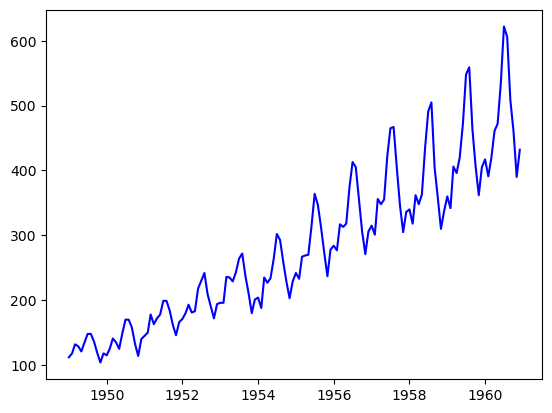

In [6]:
plt.plot(df['ds'], df['y'], '-b')
plt.show()

#### **Observamos que tenemos una tendencia creciente, con una estacionalidad anual muy marcada.**

In [7]:
df.info()   # no hay datos perdidos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      144 non-null    datetime64[ns]
 1   y       144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [8]:
# Particionemos en entrenamiento y prueba:

train = df.iloc[0:-12,:]    # train y test son DataFrames.

test = df.iloc[-12:,:]   # Seleccionamos los datos del último año para predicción.

# **1 - Modelo ingenuo (Baseline / Persistance / Naive model)**

In [11]:
history = [x for x in train['y']]   # Definimos "history" donde de manera incremental se irán agregando registros mensuales.
predictions = list()    # Lista que contendrá las predicciones del modelo ingenuo.

for i in range(len(test['y'])):
  # Obtenemos las predicciones:
  yhat = history[-1]   # La primera vez, tomamos el último dato del Train, en las siguientes, se van agregando los datos de Test.
  predictions.append(yhat)

  # Observaciones-registros reales:
  obs = test.iloc[i,1]   # Ahora vamos tomando los datos de Test.
  history.append(obs)  # Vamos agregando a "history" (que ya tiene todo los de Train) en cada iteración, un dato más de los de Test.
  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))


# Calculamos la raíz del error cuadrático medio (RMSE):
rmse = np.sqrt(mean_squared_error(test['y'], predictions))
print('\nError-Modelo-Naive: RMSE: %.3f' % rmse)

>Esperado-real = 417, Predicción = 405.000
>Esperado-real = 391, Predicción = 417.000
>Esperado-real = 419, Predicción = 391.000
>Esperado-real = 461, Predicción = 419.000
>Esperado-real = 472, Predicción = 461.000
>Esperado-real = 535, Predicción = 472.000
>Esperado-real = 622, Predicción = 535.000
>Esperado-real = 606, Predicción = 622.000
>Esperado-real = 508, Predicción = 606.000
>Esperado-real = 461, Predicción = 508.000
>Esperado-real = 390, Predicción = 461.000
>Esperado-real = 432, Predicción = 390.000

Error-Modelo-Naive: RMSE: 53.152


#### **Este valor de predicción RMSE nos dice que en promedio el error es de aproximadamente más menos 53 pasajeros por cada predicción hecha.**

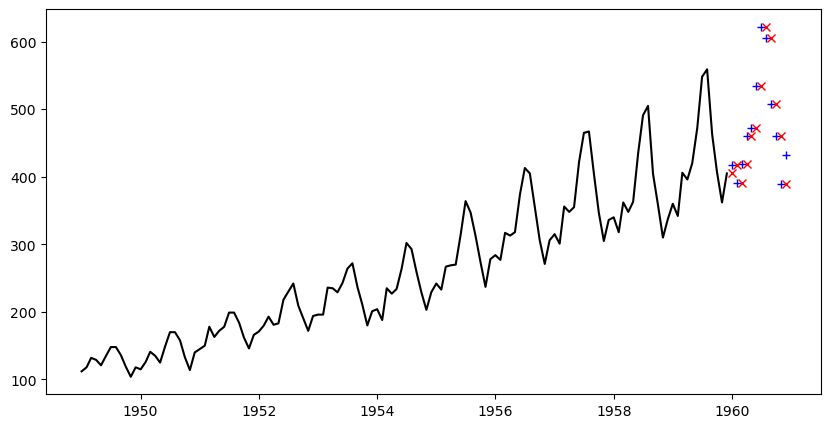

In [12]:
# Grafiquemos los resultados:

fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.plot(train['ds'], train['y'], '-k')  # Datos de entrenamiento de 1949 a 1959.
ax = plt.plot(test['ds'], test['y'], '+b')    # Datos de prueba del año 1960.
ax = plt.plot(test['ds'], predictions, 'xr')  # Predicciones del modelo del año 1960.

#### **Aunque pareciera que los datos están bastante exactos en el gráfico, en realidad están todas desfasados un año.**

# **2 - Modelo Facebook-Prophet**

#### **En la liga del modelo Facebook-Prophet puedes encontrar mucho más información, además de la documentación correspondiente:**

https://facebook.github.io/prophet/

In [17]:
# Aplicamos el modelo Facebbok-Prophet a nuestros datos:

model = Prophet()
model.fit(train)

19:59:50 - cmdstanpy - INFO - Chain [1] start processing
19:59:50 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
# Calculamos el error RMSE:

pred_FP = model.predict(test)['yhat']

rmse = np.sqrt(mean_squared_error(test['y'], pred_FP))

print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)


Error-Modelo-FacebookProphet: RMSE: 43.069


#### **Observa que se obtiene un mejor resultado que el del modelo ingenuo.**

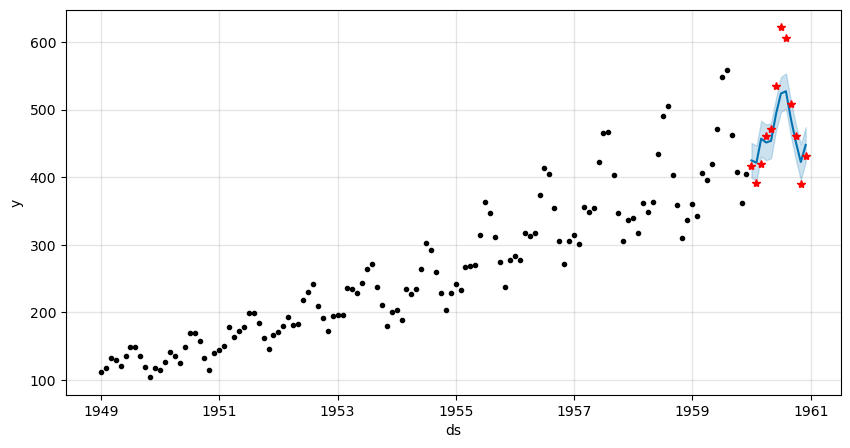

In [20]:
# La librería misma nos permite obtener las predicciones con las cotas mínima
# y máxima, además de su gráfica, como se muestra a continuación:

forecast = model.predict(test)

fig, ax = plt.subplots(figsize=(10, 5))
model.plot(forecast, ax=ax)    # La predicciones se muestran con la línea contínua y la región de variabilidad de la predicción.
ax = plt.plot(test['ds'], test['y'], '*r')   # Agregamos los datos de prueba (Test), para observar la diferencia.


# **3 - Modelo ARIMA/SARIMA**

#### **En el modelo SARIMA, el significado de sus iniciales S-AR-I-MA está dado como sigue:**

*   #### **S:** Seasonality-Estacionalidad: componente que modela la estacionalidad de los datos.

*   #### **AR:** Autoregresive: es la componente autoregresiva que modela-correlaciona lo que viene sucediendo en el pasado para predecir lo que sucederá en el futuro.

*   #### **I:** Integrated: es la componente "integrada" que transforma series de datos no-estacionarios en estacionarios (i.e., donde la media y varianza permanecen constantes a lo largo del tiempo) mediante diferencias de datos consecutivos.

*   #### **MA:** Moving Average-Promedios Móviles.



In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [14]:
# Esto es para quitar lo de la estacionalidad y en transformar un problema
# de tipo estacionario (SARIMA) en un estacionario (ARIMA):

# Diferencia de datos consecutivos en el tiempo --> Esto quita la Estacionalidad
# y podemos ahora usar ARIMA:
def difference(dataset, interval=1):
  diff = list()

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return np.array(diff)



# Invierte las diferencias anteriores, es decir, nos regresa la estacionalidad:
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]


In [15]:
# Definamos la siguiente lista de registros de pasajeros en el tiempo:
history = [x for x in train.loc[:,'y']]   # train-ndarray : columna solo con los registros de pasajeros "y".
                               # history-list : lista con los datos del train.

predictions = list()   # Para incluir las predicciones que vaya generando el modelo.

for i in range(len(test['y'])):
  #
  months_in_year = 12
  diff = difference(history, months_in_year)    # diff-list: tiene la forma: [array([-274.], dtype=float32),array([-197.], dtype=float32),...

  # Generamos el modelo.
  model = ARIMA(diff, order=(1,0,0))   # Este es de los mejores modelos que se obtienen. Puedes cambiar los órdenes en dado caso.
  model_fit = model.fit()

  yhat = model_fit.forecast()[0]   # prediccions (yhat) de cada registro, es un solo número flotante.
  yhat = inverse_difference(history, yhat, months_in_year)    # El "history" sigue siendo la lista de arriba.
                                                              # El nuevo "yhat" es cada un nuevo valor (float) de predicción.
  predictions.append(yhat)  # predictions-list : lista que se va incrementando al ir agregando cada predicción nueva.

  # Observaciones-reales:
  obs = test.iloc[i,1]   #  cada dato es un flotante.
  history.append(obs)   #  history-list : se va incrementado a partir del Train con los registros-observaciones reales.

  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

# Error RMSE:
rmse = np.sqrt(mean_squared_error(test['y'], predictions))
print('\nRMSE: %.3f' % rmse)

>Esperado-real = 417, Predicción = 420.885
>Esperado-real = 391, Predicción = 393.837
>Esperado-real = 419, Predicción = 451.325
>Esperado-real = 461, Predicción = 412.437
>Esperado-real = 472, Predicción = 476.873
>Esperado-real = 535, Predicción = 518.834
>Esperado-real = 622, Predicción = 603.579
>Esperado-real = 606, Predicción = 623.791
>Esperado-real = 508, Predicción = 506.266
>Esperado-real = 461, Predicción = 448.762
>Esperado-real = 390, Predicción = 410.812
>Esperado-real = 432, Predicción = 433.748

RMSE: 20.323


#### **Se obtiene un mejor modelo que el modelo ingenuo y el de Prophet**

#### **También se podría buscar mejorar el modelo con los hiperparámetros de estacionalidad SARIMA(P, D, Q, s). Puedes revisar la documentación respectiva, pero por el momento nos quedamos con este resultado como primera aproximación.**


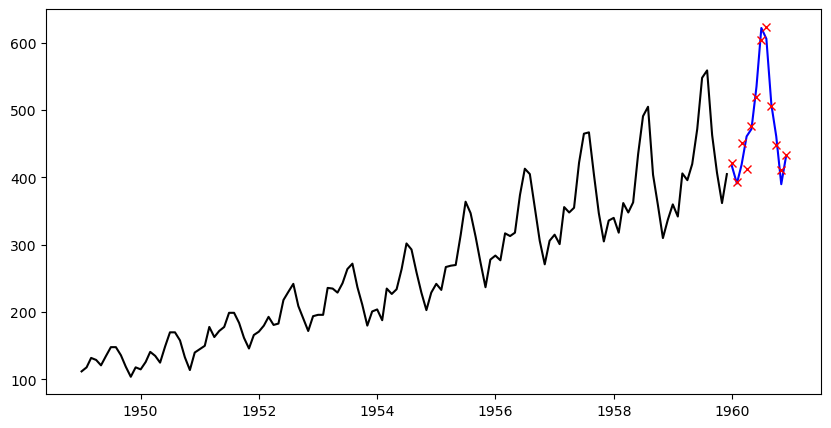

In [16]:
# Veamos su gráfico:
fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.plot(train['ds'], train['y'], '-k')
ax = plt.plot(test['ds'], test['y'], '-b')
ax = plt.plot(test['ds'], predictions, 'xr')

# **4 - Long Short Term Memory (LSTM)**

In [22]:
import tensorflow as tf

In [23]:
def preparando_datos(myData, myDate):

  # ++++++++ TRAIN +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Los datos de entrenamiento son previos a la fecha "Date" que indiques y
  # tomarán hisotriales en este caso de 12 períodos previos.
  Train_Data = myData['y'][myData['ds'] < myDate].to_numpy()

  periodo = 12   # 12 meses al año

  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []

  for i in range(0, len(Train_Data), periodo):    # observa que va formando el Train set con historiales de 12 períodos consecutivos.
    try:
      Data_Train.append(Train_Data[i : i + periodo])
    except:
      pass


  # En ocasiones hay datos perdidos, en cuyo caso la última serie
  # de datos la eliminamos:
  if len(Data_Train[-1]) < periodo:
    Data_Train.pop(-1)


  # Hay quedarle la forma dimensionalidad que requieren los modelos
  # de aprendizaje profundo, en particular la librería de TensorFlow:
  #     (batch_size, sequence_length, input_dimension).

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, periodo, 1))

  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, periodo, 1))


  # +++++++++++ TEST +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Los datos de prueba (Test) son posteriores a la fecha "Date" y que es el
  # último ciclo que deseas predecir:
  Test_Data = myData['y'][myData['ds'] >= myDate].to_numpy()

  # inicialización de listas:
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []

  for i in range(0, len(Test_Data), periodo):
    try:
      Data_Test.append(Test_Data[i : i + periodo])
    except:
      pass


  if len(Data_Test[-1]) < periodo:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, periodo, 1))

  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, periodo, 1))


  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y


In [24]:
threshold_Date = '1959-01-01'   # A partir de esta fecha se empieza a generar el Test.
                                # En este caso, el Text_X serán los 12 meses de 1959
                                # y el Test_Y serán los de 1960.

# Recuerda que la columna de fechas del DataFrame df, debe ser de tipo DateTime.
# Se generan paquetes de 12 meses. Los *_Y son los años desfasados hacia adelante
# de los *_X:

Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df, threshold_Date)

In [25]:
# Podemos definir la manera en que el tamaño de paso (learning-rate) varíe
# en cada época. Es usual definir también algunas funciones, exponenciales,
# por ejemplo. Por el momento definamos valores constantes por intervalos:

def scheduler(epoch):

  if epoch <= 100:
    lrate = 0.05
  elif epoch <= 180:
    lrate = 0.0005
  elif epoch <=190:
    lrate = 0.00005
  else:
    lrate = (10 ** -5)

  return lrate


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [34]:
Train_Y = Train_Y.astype(np.float32)
Test_Y = Test_Y.astype(np.float32)



Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 75275.1484 - root_mean_squared_error: 274.3632 - val_loss: 39069.4844 - val_root_mean_squared_error: 197.6600 - learning_rate: 0.0500
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 72586.5391 - root_mean_squared_error: 269.4189 - val_loss: 3885178.0000 - val_root_mean_squared_error: 1971.0854 - learning_rate: 0.0500
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 61265.5469 - root_mean_squared_error: 247.5188 - val_loss: 707073088.0000 - val_root_mean_squared_error: 26590.8457 - learning_rate: 0.0500
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 27129.3418 - root_mean_squared_error: 164.7099 - val_loss: 11769856000.0000 - val_root_mean_squared_error: 108488.9688 - learning_rate: 0.0500
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 14811.1543 - root_mean_squared_error: 121.7011 - val_loss: 620320064.0000 - val_root_mean_squared_error: 24906.2246 - learning_rate: 0.0500
Epoch 6/300
1/1 ━━

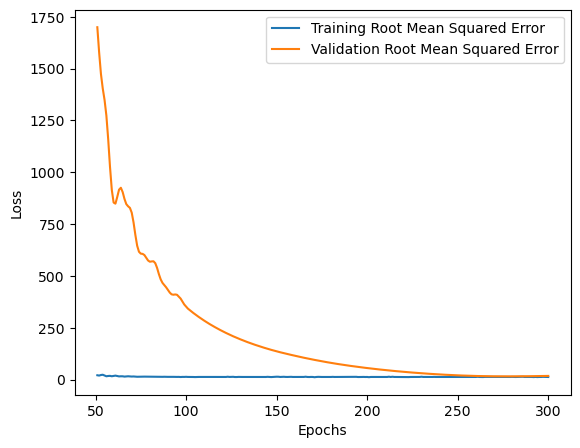

In [35]:
def myModel():

  model = tf.keras.models.Sequential([tf.keras.layers.LSTM(20, input_shape=(12, 1), activation=tf.nn.leaky_relu, return_sequences=True),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.LSTM(20, activation=tf.nn.leaky_relu),
                                      tf.keras.layers.BatchNormalization(),

                                      tf.keras.layers.Dense(200, activation=tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(120, activation=tf.nn.leaky_relu),
                                      tf.keras.layers.Dropout(0.001),

                                      tf.keras.layers.Dense(12, activation=tf.nn.leaky_relu)
                                      ])
  return model


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


my_LSTM_model2 = myModel()

my_LSTM_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='mse',
                      metrics=[tf.keras.metrics.RootMeanSquaredError()]
                      )


H = my_LSTM_model2.fit(Train_X,
                      Train_Y,
                      epochs=300,
                      validation_data=(Test_X, Test_Y),
                      callbacks=[callback]
                      )



N = 50  # Para omitir los N primeros valores en la gráfica, que en ocasiones son
        # demasiado grandes los errores y no dejan apreciar las curvas de aprendizaje.

epochs = range(N+1, len(H.history["loss"]) + 1)

fig, ax2 = plt.subplots()
fig.set_figheight(5)
ax2.plot(epochs, H.history["root_mean_squared_error"][N:], label = "Training Root Mean Squared Error")
ax2.plot(epochs, H.history["val_root_mean_squared_error"][N:], label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

>> ## **Fin del Ejercicio de Series de Tiempo**